In [1]:
# print(plt.style.available)
# matplotlib.use('Agg')
# warnings.filterwarnings("ignore", category=UserWarning)

# Modules

In [2]:
from MyModule import *

In [3]:
plt.rcParams.update({'figure.max_open_warning': 20})

In [4]:
census_data = pd.read_excel(r'C:\Users\ayazici\Documents\census.xlsx', sheet_name='Study')

In [5]:

def decide():
    def get_values():
        global run_scripts_value, load_data_value
        run_scripts_value = run_scripts_var.get()
        load_data_value = load_data_var.get()
        dialog.destroy()

    dialog = tk.Tk()
    dialog.title("Configuration")

    # Variables pour stocker l'état des cases à cocher
    run_scripts_var = tk.BooleanVar()
    load_data_var = tk.BooleanVar()

    # Cases à cocher pour les options
    run_scripts_checkbox = ttk.Checkbutton(dialog, text="Run Scripts", variable=run_scripts_var)
    load_data_checkbox = ttk.Checkbutton(dialog, text="Load Data", variable=load_data_var)

    # Bouton pour valider les choix
    confirm_button = ttk.Button(dialog, text="Valider", command=get_values)

    # Placement des widgets dans la fenêtre
    run_scripts_checkbox.grid(row=0, column=0, padx=10, pady=5, sticky="w")
    load_data_checkbox.grid(row=1, column=0, padx=10, pady=5, sticky="w")
    confirm_button.grid(row=2, column=0, padx=10, pady=10)

    dialog.mainloop()



def select_animals(census_data):
    exp_ids = []
    boolean_var = []

    def valider():
        for i, var in enumerate(var_etats):
            boolean_var.append(var.get())
            if var.get()==True:
                exp_ids.append(noms[i])
                print(f"{noms[i]} ({descriptions[i]})")
        root.destroy()

    def check_all():
        for var in var_etats:
            var.set(True)

    def uncheck_all():
        for var in var_etats:
            var.set(False)

    def update_checkboxes(description):
        for i, desc in enumerate(descriptions):
            if desc == description:
                var_etats[i].set(var_description_states[description].get())

    noms = census_data['exp_id']
    descriptions = census_data['description']

    root = tk.Tk()
    root.title("Interface avec cases à cocher")

    root.geometry("1000x500")

    canvas = tk.Canvas(root)
    scrollbar = ttk.Scrollbar(root, orient="vertical", command=canvas.yview)
    scrollable_frame = ttk.Frame(canvas)

    scrollable_frame.bind(
        "<Configure>",
        lambda e: canvas.configure(
            scrollregion=canvas.bbox("all")
        )
    )
    canvas.create_window((0, 0), window=scrollable_frame, anchor="center")
    canvas.configure(yscrollcommand=scrollbar.set)

    var_etats = []

    for i, nom in enumerate(noms):
        var = tk.BooleanVar()
        var_etats.append(var)

        checkbox = tk.Checkbutton(scrollable_frame, text=f"{nom}", font=("Arial", 11, "bold"), fg='blue', variable=var)
        checkbox.grid(row=i, column=0, sticky="w")
        label = tk.Label(scrollable_frame, text=f"({descriptions[i]})", font=("Arial", 10, "italic"))
        label.grid(row=i, column=1, sticky="w")

    canvas.pack(side="left", fill="both", expand=True)
    scrollbar.pack(side="right", fill="y")

    btn_valider = tk.Button(root, text="Valider", command=valider)
    btn_valider.pack(side="bottom", padx=5, pady=5)

    btn_check_all = tk.Button(root, text="Check All", command=check_all)
    btn_check_all.pack(side="bottom", padx=5, pady=25)

    btn_uncheck_all = tk.Button(root, text="Uncheck All", command=uncheck_all)
    btn_uncheck_all.pack(side="bottom", padx=5, pady=5)

    var_description_states = {}
    for description in set(descriptions):
        var_description_states[description] = tk.BooleanVar()
        checkbox = tk.Checkbutton(root, text=description, variable=var_description_states[description], command=lambda desc=description: update_checkboxes(desc))
        checkbox.pack(side="left", padx=5, pady=5)

    root.mainloop()

    return exp_ids, boolean_var




def write_on_notebook(notebook_path, text, cell_number):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    nb['cells'][cell_number]['source'] = text

    with open(notebook_path, 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)




def multi_animal_analysis(census_data):
    decide()

    if run_scripts_value:
        print("RUNNING THE SCRIPTS...")
        exp_ids, boolean_var = select_animals(census_data)
        raw_data_paths = census_data.loc[boolean_var, 'raw_data_path']
        scripts = census_data.loc[boolean_var, 'script']
        scripts = [script.split(', ') for script in scripts]

        %matplotlib qt
        for raw_data_path, exp_id, animal_script in tqdm(zip(raw_data_paths, exp_ids, scripts), total=len(exp_ids), desc='Processing the multi-animal analysis...', leave=True):
            print('\n')
            nom_fichier_sortie = fr'C:\Users\ayazici\Documents\Analyses\{exp_id}\output.txt'
            if not os.path.exists(os.path.dirname(nom_fichier_sortie)):
                os.makedirs(os.path.dirname(nom_fichier_sortie), exist_ok=True)
            sys.stdout = open(nom_fichier_sortie, 'w')
            for script in animal_script:
                os.makedirs(fr'C:\Users\ayazici\Documents\Analyses\{exp_id}\scripts', exist_ok=True)
                filename = os.path.basename(script)
                new_script = fr'C:\Users\ayazici\Documents\Analyses\{exp_id}\scripts\{filename.replace('.ipynb', f"_{exp_id}.ipynb")}'
                shutil.copyfile(script, new_script)

                write_on_notebook(new_script, f'raw_data_path = r"{raw_data_path}"', 2)

                %run {new_script}
                
                plt.close('all')
                
                print('-'*100)
                print('\n')
            
            foo = saving_folder
            while exp_id not in os.path.basename(foo):
                foo = os.path.dirname(foo)
            if os.name == 'posix':  # Unix (Linux, macOS)
                subprocess.Popen(['xdg-open', foo])
            elif os.name == 'nt':  # Windows
                subprocess.Popen(['explorer', foo])
            sys.stdout = sys.__stdout__
            display(FileLink(nom_fichier_sortie))
            print('\n')
        %matplotlib inline
    
    if load_data_value:
        global rotation_data, phototagging_data
        rotation_data = {}
        phototagging_data = {}

        print("LOADING THE DATA...")
        exp_ids, boolean_var = select_animals(census_data)
        analysis_data_paths = census_data.loc[boolean_var, 'analysis_data_path']
        for exp_id, analysis_data_path in tqdm(zip(exp_ids, analysis_data_paths), total=len(exp_ids), desc='Loop over animals'):
            for file in os.listdir(analysis_data_path):
                if file.endswith('.pickle') and 'rotation' in file:
                    rotation_data[exp_id] = pd.read_pickle(os.path.join(analysis_data_path, file))
                elif file.endswith('.pickle') and 'phototagging' in file:
                    phototagging_data[exp_id] = pd.read_pickle(os.path.join(analysis_data_path, file))
        # data = load_data(census_data)
        # return data

    #run_scripts_value, load_data_value = False, False

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)
multi_animal_analysis(census_data)

LOADING THE DATA...
animal21_a15d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a17d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a18d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a19d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a21d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a51d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal21_a53d1s1 (DCN, phototagging, response to head rotation in pitch dark)
animal20_a40d1s1 (Rotation in light and dark, with stitched eye)
animal20_a41d1s1 (Rotation in light and dark, with stitched eye)
animal21_a45d1s2 (Rotation in light and dark, with stitched eye)


Loop over animals: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


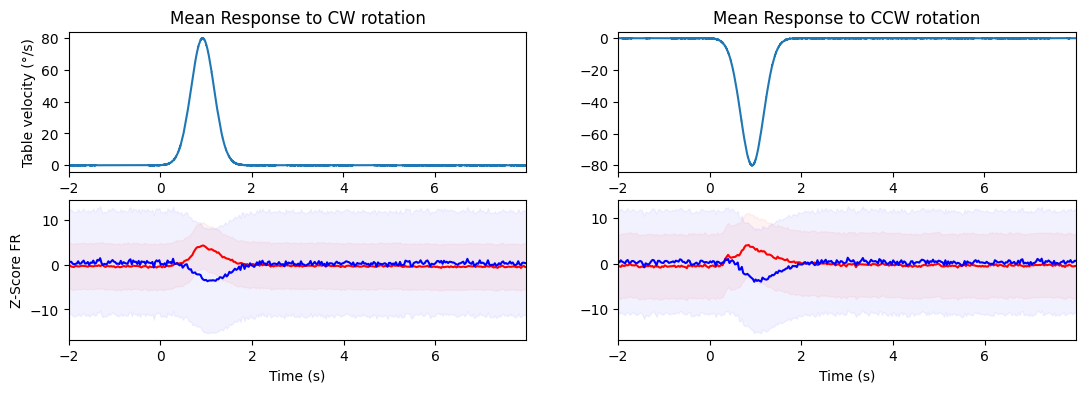

In [7]:
foo1 = np.concatenate([rotation_data[animal]['modulation']['selectivity'] for animal in rotation_data])
foo2 = np.concatenate([rotation_data[animal]['modulation']['type'] for animal in rotation_data])
CWp = ((foo1 == 'CW') & (foo2 == '+')) | ((foo1 == 'both') & ((foo2 == '++') | (foo2 == '+-')))
CWn = ((foo1 == 'CW') & (foo2 == '-')) | ((foo1 == 'both') & ((foo2 == '-+') | (foo2 == '--')))
CCWp = ((foo1 == 'CCW') & (foo2 == '+')) | ((foo1 == 'both') & ((foo2 == '++') | (foo2 == '+-')))
CCWn = ((foo1 == 'CCW') & (foo2 == '-')) | ((foo1 == 'both') & ((foo2 == '+-') | (foo2 == '--')))

spikeobject = {'CW':{'+':[], '-':[]},
               'CCW':{'+':[], '-':[]}}


for direction, positive, negative in zip(['CW', 'CCW'], [CWp, CCWp], [CWn, CCWn]):
    foo = [rotation_data[animal]['SpikeTimes'][direction] for animal in rotation_data]
    index = 0
    for animal_i, animal_spikes in enumerate(foo):
        for i, unit_spikes in enumerate(animal_spikes):
            if positive[index]:
                spikeobject[direction]['+'].append(unit_spikes)
            if negative[index]:
                spikeobject[direction]['-'].append(unit_spikes)
            index += 1

plt.figure(figsize=(13,4))
plt.subplot(221)
plt.plot(rotation_data['animal20_a40d1s1']['duration'], rotation_data['animal20_a40d1s1']['MeanRotation']['CW'])
plt.title('Mean Response to CW rotation')
plt.margins(x=0)
plt.ylabel('Table velocity (°/s)')
plt.subplot(222)
plt.plot(rotation_data['animal20_a40d1s1']['duration'], rotation_data['animal20_a40d1s1']['MeanRotation']['CCW'])
plt.title('Mean Response to CCW rotation')
plt.margins(x=0)

for condition, loc in zip(['CW', 'CCW'], [223, 224]):
    for sign in ['+', '-']:
        StudiedSpikeTimes = spikeobject[condition][sign]
        
        spike_number_per_trial = [[[] for _ in unit] for unit in StudiedSpikeTimes]

        edges = []

        for unit in range(len(StudiedSpikeTimes)):
            for trial in range(len(StudiedSpikeTimes[unit])):
                spike_number_per_trial[unit][trial], edges = np.histogram(StudiedSpikeTimes[unit][trial], bins=np.arange(-2, 8 + 0.03, 0.03))
        
        SpikeNumberPerTrial = []
        for unit in range(len(spike_number_per_trial)):
            for trial in range(len(spike_number_per_trial[unit])):
                SpikeNumberPerTrial.append(spike_number_per_trial[unit][trial])
            
        trial_number = len(SpikeNumberPerTrial)

        frequency_per_trial = [[SpikeNumberPerTrial[trial][bin]/0.03 for bin in range(len(edges)-1)] for trial in range(trial_number)]
        mean_frequency = [np.mean([SpikeNumberPerTrial[trial][bin] for trial in range(trial_number)]) for bin in range(len(edges)-1)]

        Zscore = (mean_frequency - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))
        Zscore[-1]=Zscore[-2]
        Zunitary = (frequency_per_trial - np.mean(mean_frequency)) / np.std(mean_frequency) if np.std(mean_frequency) != 0 else np.zeros(len(frequency_per_trial))
        SEM = np.std(Zunitary)/np.sqrt(len(Zunitary)) if np.std(mean_frequency) != 0 else np.zeros(len(mean_frequency))

        # plt.figure(figsize=(15,6))
        plt.subplot(loc)
        color='r' if sign=='+' else 'b'
        plt.plot(edges[:-1], Zscore, color=color)
        plt.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.05, color=color)

        plt.ylabel('Z-Score FR') if loc==223 else None
        plt.xlabel('Time (s)')
        plt.margins(x=0)
                
plt.show()

Combien de neurones sont supprimés en se basant sur leur fréquence de décharge en baseline ?

In [15]:
print('Nombre de neurones jugés corrects ', sum(np.concatenate([rotation_data[animal]['good_baseline'] for animal in rotation_data])))
print('Nombre total de neurones ',len(np.concatenate([rotation_data[animal]['good_baseline'] for animal in rotation_data])))

Nombre de neurones jugés corrects  367
Nombre total de neurones  391


# Initiation

# Analysis

## Figure 1

Nous cherchons à savoir comment le système visuel traite les informations visuelles pour les transformer en une représentation interne de l'environnement externe, en prenant en compte les informations contextuelles que sont les mouvements oculaires et de la tête.

Le système vestibulaire implique de façon précoce les noyaux vestibulaires et profonds cérébelleux. Par injection de virus transsynpatiques, on réalise que les DCN notamment sont à l'origine d'un certain nombre de projections axonales dans une région thalamique : le pulvinar.

Or, on sait que les neurones du pulvinar ont une activité modulée par les saccades.

La question sous-tendue est la suivante : les neurones du pulvinar sont-ils modulés par les mouvements de tête ?

### vMI

In [9]:
# RECHERCHE D'UNITS PARTICULIERS
max_vMI, min_vMI, nul_vMI = {}, {}, {}

for direction in ['CW', 'CCW']:
    max_vMI[direction] = max(np.concatenate([[value for i, value in enumerate(rotation_data[animal]['vMI'][direction]) if rotation_data[animal]['good_baseline'][i]] for animal in rotation_data]))
    min_vMI[direction] = min(np.concatenate([[value for i, value in enumerate(rotation_data[animal]['vMI'][direction]) if rotation_data[animal]['good_baseline'][i]] for animal in rotation_data]))
    nul_vMI[direction] = min([min([value for i, value in enumerate(rotation_data[animal]['vMI'][direction]) if rotation_data[animal]['good_baseline'][i]] , key=lambda x: abs(x)) for animal in rotation_data])

In [10]:
# EXPLORATION DES DONNEES POUR TROUVER CES UNITS
max_unit, min_unit, nul_unit = {}, {}, {}

print("vMI values :\n")

for direction in ['CW', 'CCW']:
    print(direction, ":")
    for animal in rotation_data:
        for i, unit in enumerate(rotation_data[animal]['vMI'][direction]):
            
            if unit == max_vMI[direction]:
                print(f"Max  --  {animal} unit {i}  ({unit})") ; max_unit[direction] = [animal, i]
            elif unit == min_vMI[direction]:
                print(f"Min  --  {animal} unit {i}  ({unit})") ; min_unit[direction] = [animal, i]
            elif unit == nul_vMI[direction]:
                print(f"Nul  --  {animal} unit {i}  ({unit})") ; nul_unit[direction] = [animal, i]
    print('\n') if direction == 'CW' else None

vMI values :

CW :
Max  --  animal21_a17d1s1 unit 10  (0.7643678160919541)
Min  --  animal21_a19d1s1 unit 62  (-0.86)
Nul  --  animal20_a40d1s1 unit 13  (-0.03678929765886288)


CCW :
Max  --  animal21_a17d1s1 unit 4  (0.8866279069767441)
Nul  --  animal21_a21d1s1 unit 23  (-0.008849557522123895)
Min  --  animal21_a45d1s2 unit 10  (-0.8709677419354839)


In [11]:
saving_path = r'C:\Users\ayazici\Documents\Analyses'

In [134]:
nested_list = [[1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12]]

# Trouver la longueur maximale parmi les sous-listes
max_length = max(len(sublist) for sublist in nested_list)

# Remplir les sous-listes avec des valeurs manquantes (par exemple, des zéros) pour les aligner sur la longueur maximale
padded_list = [sublist + [None] * (max_length - len(sublist)) for sublist in nested_list]

# Convertir la liste rembourrée en un tableau NumPy
nested_array = np.asarray(padded_list)

# print(nested_array)
boolean = np.asarray([True, False, False])

print(nested_array)

plt.plot(nested_array[1], 'o')
plt.show()

[[1 2 3 4 None]
 [5 6 7 8 9]
 [10 11 12 None None]]


In [77]:
def vMI_function(AllData,
                s=100, alpha=0.6, color='c', scale=0.008, binsNumber=30,
                ML=True, AP=True, CW=True, CCW=True, stats=False, hist=False, interest=None,
                size=(13,10),
                xfontsize=10, yfontsize=10, suptitlefontsize=14,
                save=False, filename='',
                show=True):
    # INITIATION
    stereotaxic_title, stereotaxic_label, direction_selected = [], [], []

    if ML:
        stereotaxic_title.append('Mediolateral')
        stereotaxic_label.append('ML_pos')
    if AP:
        stereotaxic_title.append('Anteroposterior')
        stereotaxic_label.append('AP_pos')
    if CW:
        direction_selected.append('CW')
    if CCW:
        direction_selected.append('CCW')

    modulation_quantity = dict() if (stats and hist) else None


    # LOOPS
    for pos_title, posOrientation in zip(stereotaxic_title, stereotaxic_label):
        for direction in direction_selected:

            # IMPORTATION OF DATA
            NtotClust = np.sum([sum(AllData[animal]['good_baseline']) for animal in AllData])
            AllDepth = np.concatenate([[depth for i, depth in enumerate(AllData[animal]['AllDepth']) if AllData[animal]['good_baseline'][i]] for animal in AllData])
            vMI = np.concatenate([[value for i, value in enumerate(AllData[animal]['vMI'][direction]) if AllData[animal]['good_baseline'][i]] for animal in AllData])
            pos = [AllData[animal][posOrientation] for animal in AllData]
            position = np.concatenate([np.random.normal(loc=pos[i], scale=scale, size=(sum(AllData[animal]['good_baseline']), 1)) for animal, i in zip(AllData, range(len(pos)))])


            maximum_value = max([max([value for i, value in enumerate(AllData[animal]['vMI'][direction]) if AllData[animal]['good_baseline'][i]]) for animal in AllData])
            minimum_value = min([min([value for i, value in enumerate(AllData[animal]['vMI'][direction]) if AllData[animal]['good_baseline'][i]]) for animal in AllData])
            nul_value = min([min([value for i, value in enumerate(AllData[animal]['vMI'][direction]) if AllData[animal]['good_baseline'][i]], key=lambda x: abs(x)) for animal in AllData])


            

            # CREATING DATA FOR PLOT
            if stats:
                AllHow = np.concatenate([[value for i, value in enumerate(AllData[animal]['modulation']['type']) if AllData[animal]['good_baseline'][i]] for animal in AllData])
                AllWho = np.concatenate([[value for i, value in enumerate(AllData[animal]['modulation']['selectivity']) if AllData[animal]['good_baseline'][i]] for animal in AllData])

                condition_positive, condition_negative, condition_unmodulated = [], [], []

                if direction == 'CW':
                    for i in range(NtotClust):
                        condition_positive.append((AllWho[i] == 'CW' or AllWho[i] == 'both') and (AllHow[i] == '+' or AllHow[i] == '+/+' or AllHow[i] == '+/-'))
                        condition_negative.append((AllWho[i] == 'CW' or AllWho[i] == 'both') and (AllHow[i] == '-' or AllHow[i] == '-/+' or AllHow[i] == '-/-'))
                        condition_unmodulated.append(AllWho[i] == 'unmodulated' or AllWho[i] == 'CCW')
                elif direction == 'CCW':
                    for i in range(NtotClust):
                        condition_positive.append((AllWho[i] == 'CCW' or AllWho[i] == 'both') and (AllHow[i] == '+' or AllHow[i] == '+/+' or AllHow[i] == '-/+'))
                        condition_negative.append((AllWho[i] == 'CCW' or AllWho[i] == 'both') and (AllHow[i] == '-' or AllHow[i] == '+/-' or AllHow[i] == '-/-'))
                        condition_unmodulated.append(AllWho[i] == 'unmodulated' or AllWho[i] == 'CW')


                positionSigni_P = [position[i] for i in range(NtotClust) if condition_positive[i]]
                depthSigni_P = [AllDepth[i] for i in range(NtotClust) if condition_positive[i]]
                vMISigni_P = [vMI[i] for i in range(NtotClust) if condition_positive[i]]

                positionSigni_N = [position[i] for i in range(NtotClust) if condition_negative[i]]
                depthSigni_N = [AllDepth[i] for i in range(NtotClust) if condition_negative[i]]
                vMISigni_N = [vMI[i] for i in range(NtotClust) if condition_negative[i]]

                positionNot = [position[i] for i in range(NtotClust) if condition_unmodulated[i]]
                depthNot = [AllDepth[i] for i in range(NtotClust) if condition_unmodulated[i]]
                vMINot = [vMI[i] for i in range(NtotClust) if condition_unmodulated[i]]

                positionData = [positionSigni_P, positionSigni_N, positionNot]
                depthData = [depthSigni_P, depthSigni_N, depthNot]
                vMIData = [vMISigni_P, vMISigni_N, vMINot]

                if hist:
                    histdata2 = [] ; bins2 = [] ; histdataDist2 = []
                    histdata3 = [] ; bins3 = [] ; histdataDist3 = []

                    for data in [depthSigni_P, depthSigni_N]:
                        histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                        histdata2.append(histdatafoo) ; bins2.append(binsfoo)
                        histdataDist2.append(histdatafoo / NtotClust * 100)

                    for data in [positionSigni_P, positionSigni_N]:
                        histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                        histdata3.append(histdatafoo) ; bins3.append(binsfoo)
                        histdataDist3.append(histdatafoo / NtotClust * 100)

                    modulation_label = ['Excitation', 'Suppression', 'No modulation']
                    modulation_quantity[direction] = [len(positionSigni_P), len(positionSigni_N), len(positionNot)]
            elif not stats:
                if hist:
                    histdata3, bins3 = np.histogram(position, bins=binsNumber)
                    histdataDist3 = histdata3 / NtotClust * 100

                    histdata2, bins2 = np.histogram(AllDepth, bins=binsNumber)
                    histdataDist2 = histdata2 / NtotClust * 100

                positionData = position
                depthData = AllDepth
                vMIData = vMI
            ############################################################





            # mettre en évidence les neurones d'intérêt
            if interest!=None:
                wanted_array = []
                for value in interest:
                    if value == 'max':
                        wanted_array.append(maximum_value)
                    elif value == 'min':
                        wanted_array.append(minimum_value)
                    elif value == 'nul':
                        wanted_array.append(nul_value)
                    else:
                        wanted_array.append(value)
            ############################################################





            # PLOTTING DATA
            fig = plt.figure(figsize=size)

            ## Creating axis
            if hist:
                gs = GridSpec(nrows=4, ncols=4)
                ax1 = fig.add_subplot(gs[1:4,0:3]) ; # scatter plot on the left
                ax2 = fig.add_subplot(gs[1:4,3], sharey=ax1) ;  # histogram on the right
                ax3 = fig.add_subplot(gs[0,0:3], sharex=ax1) ;  # histogram on the top
                # ax4 = fig.add_subplot(gs[0,3]) if stats else None
            ############################################################




            ## Highlighting units of interest
            if interest!=None:
                for value in wanted_array:
                    ax = ax1 if hist else plt
                    if type(value) == list:
                        values_of_interest = [vMI_value for vMI_value in vMI if value[0] <= vMI_value <= value[1]]
                        for value in values_of_interest:
                            unit_index = np.where(vMI == value)[0]
                            ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2) if len(unit_index) > 0 else None
                    else:
                        unit_index = np.where(vMI == value)[0]
                        if len(unit_index) > 0:
                            ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2)
            ############################################################




            ## Plots of data
            if stats:                    
                if hist:
                    for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['Excited units', 'Suppressed units', 'Non-significant modulation']):
                        ax1.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                    ax1.legend()
                    for histdata, bins, color in zip(histdataDist2, bins2, ['red', 'blue']):
                        ax2.plot(histdata, bins[:-1], color=color)
                    for histdata, bins, color in zip(histdataDist3, bins3, ['red', 'blue']):
                        ax3.plot(bins[:-1], histdata, color=color)
                    # ax4.bar(modulation_label, modulation_quantity[direction], color=['red', 'blue', 'grey'], alpha=1)
                else:
                    for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['Excited units', 'Suppressed units', 'Non-significant modulation']):
                        plt.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                    plt.legend()
            else:
                if hist:
                    ax1.scatter(positionData, depthData, s=s, alpha=alpha, color=color)
                    ax2.plot(histdataDist2, bins2[:-1], color=color)
                    ax3.plot(bins3[:-1], histdataDist3, color=color)
                else:
                    plt.scatter(positionData, depthData, c=vMI, cmap='coolwarm', s=s, alpha=alpha, clim=(minimum_value, maximum_value))                
                    plt.colorbar(label=f"{direction} modulation index"+r" : $(n_{during} - n_{before})/(n_{during} + n_{before})$") if ((not hist) and (not stats)) else None


            ## MEP
            xlabel = f"{pos_title} position (mm)"
            ylabel = r"Depth ($\mu$m)"
            histlabel = 'Density (%)' if hist else None
            # statsylabel = 'Number of units' if stats else None #(ax4)
            suptitle = f"{direction} modulation in {pos_title} axis"

            xfontsize = xfontsize
            yfontsize = yfontsize
            # statsyfontsize = 12 if stats else None #(ax4)
            suptitlefontsize = suptitlefontsize
            ############################################################

            ## Aesthetics
            if hist:
                ax1.invert_yaxis()
                ax1.invert_xaxis() if posOrientation == 'ML_pos' else None
                ax1.set_xlabel(xlabel, fontsize=xfontsize)
                ax1.set_ylabel(ylabel, fontsize=yfontsize)

                ax2.set_xlabel(histlabel, fontsize=xfontsize)
                ax2.spines['top'].set_visible(False)
                ax2.spines['right'].set_visible(False) 
                ax2.spines['bottom'].set_visible(True) 
                ax2.spines['left'].set_visible(False)
                ax2.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True)

                ax3.set_ylabel(histlabel, fontsize=yfontsize)
                ax3.spines['top'].set_visible(False)
                ax3.spines['right'].set_visible(False)
                ax3.spines['bottom'].set_visible(False)
                ax3.spines['left'].set_visible(True)
                ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelleft=True, labelbottom=False)

                # if stats:
                #     ax4.set_ylabel(statsylabel, fontsize=statsyfontsize)
                #     ax4.set_xticks(np.arange(len(modulation_label)))
                #     ax4.set_xticklabels(modulation_label, rotation=20)
            else:
                plt.gca().invert_yaxis()
                plt.gca().invert_xaxis() if posOrientation == 'ML_pos' else None
                plt.xlabel(xlabel, fontsize=xfontsize)
                plt.ylabel(ylabel, fontsize=yfontsize)
                    
            plt.suptitle(suptitle, fontsize=suptitlefontsize)
            ############################################################


            # Saving and showing
            if save:
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                if filename=='':
                    plt.savefig(os.path.join(saving_path , f"{direction}_modulation_{pos_title}.png"))
                else:
                    plt.savefig(f"{filename}.png")
            
            plt.show() if show else plt.close()
            ############################################################

            foo=dict()
            for animal in AllData:
                foo[animal] = AllData[animal][posOrientation]
            sorted_keys = [key for key, value in sorted(foo.items(), key=itemgetter(1))] 

            myTable = PrettyTable(["Animal", pos_title]) 

            for animal in sorted_keys:
                myTable.add_row([animal, foo[animal]])

            print(myTable)

        if stats and hist:
            plotdata = pd.DataFrame({'CW':modulation_quantity['CW'], 'CCW':modulation_quantity['CCW']}, index=modulation_label)
            plotdata.plot(kind="bar",figsize=(10, 5), color=['red', 'blue'], rot=25)
            plt.ylabel('Number of units')
            plt.title('Rotation modulation')
            if save:
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                if filename=='':
                    plt.savefig(os.path.join(saving_path , f"modulation_{pos_title}_barplot.png"))
                else:
                    plt.savefig(f"{filename}.png")
            if show:
                plt.show()
            else:
                plt.close()
            print('\n')

In [30]:
%matplotlib inline

In [32]:
%matplotlib qt

In [79]:
vMI_function(rotation_data, save=False, s=50, alpha=0.5, stats=True, hist=True, interest=['max', 'min', 'nul'])

367
+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a45d1s2 |     0.7      |
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal20_a41d1s1 |     0.85     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal20_a40d1s1 |     1.15     |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+
367
+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a45d1s2 |     0.7      |
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal20_a41d1s1 |     0.85     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal20_a40d1s1 |     1.15     |
| animal21_a18d1s1 |     1.22     |
+------------------+

In [76]:
def dirMI_function(AllData, filename='', path='', save=False, show=True, s=100,alpha=0.6, scale=0.008, ML=True, AP=True, stats=False, hist=False, interest=None, color='c', binsNumber=30):
    # INITIATION
    stereotaxic_title=[]
    stereotaxic_label=[]
    if ML:
        stereotaxic_title.append('Mediolateral')
        stereotaxic_label.append('ML_pos')
    if AP:
        stereotaxic_title.append('Anteroposterior')
        stereotaxic_label.append('AP_pos')

    preference_quantity = dict() if (stats and hist) else None


    # LOOPS
    for pos_title, posOrientation in zip(stereotaxic_title, stereotaxic_label):

        # IMPORTATION OF DATA
        NtotClust = np.sum([sum(AllData[animal]['good_baseline']) for animal in AllData])
        AllDepth = np.concatenate([[value for i, value in enumerate(AllData[animal]['AllDepth']) if rotation_data[animal]['good_baseline'][i]] for animal in AllData])
        dirMI = np.concatenate([[value for i, value in enumerate(AllData[animal]['dirMI']) if rotation_data[animal]['good_baseline'][i]] for animal in AllData])
        pos = [AllData[animal][posOrientation] for animal in AllData]
        position = np.concatenate([np.random.normal(loc=pos[i], scale=scale, size=(sum(AllData[animal]['good_baseline']), 1)) for animal, i in zip(AllData, range(len(pos)))])


        maximum_value = max([max([value for i, value in enumerate(AllData[animal]['dirMI']) if rotation_data[animal]['good_baseline'][i]]) for animal in AllData])
        minimum_value = min([min([value for i, value in enumerate(AllData[animal]['dirMI']) if rotation_data[animal]['good_baseline'][i]]) for animal in AllData])
        nul_value = min([min([value for i, value in enumerate(AllData[animal]['dirMI']) if rotation_data[animal]['good_baseline'][i]], key=lambda x: abs(x)) for animal in AllData])


        

        # CREATING DATA FOR PLOT
        if stats:
            AllPreferences = np.concatenate([[value for i, value in enumerate(AllData[animal]['preference']) if rotation_data[animal]['good_baseline'][i]] for animal in AllData])
            # AllPreferences = np.concatenate([[AllData[animal]['preference'][unit] for unit in range(AllData[animal]['Nclust'])] for animal in AllData])

            CW_preferrers_bool = AllPreferences == 'CW'
            CCW_preferrers_bool = AllPreferences == 'CCW'
            Non_preferrers_bool = AllPreferences == None

            
            positionCW = [position[i] for i in range(NtotClust) if CW_preferrers_bool[i]]
            depthCW = [AllDepth[i] for i in range(NtotClust) if CW_preferrers_bool[i]]
            dirMICW = [dirMI[i] for i in range(NtotClust) if CW_preferrers_bool[i]]

            positionCCW = [position[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]
            depthCCW = [AllDepth[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]
            dirMICCW = [dirMI[i] for i in range(NtotClust) if CCW_preferrers_bool[i]]

            positionNone = [position[i] for i in range(NtotClust) if Non_preferrers_bool[i]]
            depthNone = [AllDepth[i] for i in range(NtotClust) if Non_preferrers_bool[i]]
            dirMINone = [dirMI[i] for i in range(NtotClust) if Non_preferrers_bool[i]]

            positionData = [positionCW, positionCCW, positionNone]
            depthData = [depthCW, depthCCW, depthNone]
            dirMIData = [dirMICW, dirMICCW, dirMINone]

            if hist:
                histdata2 = [] ; bins2 = [] ; histdataDist2 = []
                histdata3 = [] ; bins3 = [] ; histdataDist3 = []

                for data in [depthCW, depthCCW]:
                    histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                    histdata2.append(histdatafoo) ; bins2.append(binsfoo)
                    histdataDist2.append(histdatafoo / NtotClust * 100)

                for data in [positionCW, positionCCW]:
                    histdatafoo, binsfoo = np.histogram(data, bins=binsNumber)
                    histdata3.append(histdatafoo) ; bins3.append(binsfoo)
                    histdataDist3.append(histdatafoo / NtotClust * 100)

                modulation_label = ['CW-preferring', 'CCW-preferring', 'No preference']
                preference_quantity = [len(positionCW), len(positionCCW), len(positionNone)]
        elif not stats:
            if hist:
                histdata3, bins3 = np.histogram(position, bins=binsNumber)
                histdataDist3 = histdata3 / NtotClust * 100

                histdata2, bins2 = np.histogram(AllDepth, bins=binsNumber)
                histdataDist2 = histdata2 / NtotClust * 100

            positionData = position
            depthData = AllDepth
            dirMIData = dirMI
        ############################################################





        # mettre en évidence les neurones d'intérêt
        if interest!=None:
            wanted_array = []
            for value in interest:
                if value == 'max':
                    wanted_array.append(maximum_value)
                elif value == 'min':
                    wanted_array.append(minimum_value)
                elif value == 'nul':
                    wanted_array.append(nul_value)
                else:
                    wanted_array.append(value)
        ############################################################





        # PLOTTING DATA
        fig = plt.figure(figsize=(13,10))

        ## Creating axis
        if hist:
            gs = GridSpec(nrows=4, ncols=4)
            ax1 = fig.add_subplot(gs[1:4,0:3]) ; # scatter plot on the left
            ax2 = fig.add_subplot(gs[1:4,3], sharey=ax1) ;  # histogram on the right
            ax3 = fig.add_subplot(gs[0,0:3], sharex=ax1) ;  # histogram on the top
            # ax4 = fig.add_subplot(gs[0,3]) if stats else None
        ############################################################




        ## Highlighting units of interest
        if interest!=None:
            for value in wanted_array:
                ax = ax1 if hist else plt
                if type(value) == list:
                    values_of_interest = [dirMI_value for dirMI_value in dirMI if value[0] <= dirMI_value <= value[1]]
                    for value in values_of_interest:
                        unit_index = np.where(dirMI == value)[0]
                        ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2) if len(unit_index) > 0 else None
                else:
                    unit_index = np.where(dirMI == value)[0]
                    if len(unit_index) > 0:
                        ax.scatter(position[unit_index], AllDepth[unit_index], marker='s', s=s*4, edgecolors='black', facecolors='none', linewidths=2)
        ############################################################




        ## Plots of data
        if stats:                    
            if hist:
                for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['CW-preferring', 'CCW-preferring', 'No preference']):
                    ax1.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                ax1.legend()
                for histdata, bins, color in zip(histdataDist2, bins2, ['red', 'blue']):
                    ax2.plot(histdata, bins[:-1], color=color)
                for histdata, bins, color in zip(histdataDist3, bins3, ['red', 'blue']):
                    ax3.plot(bins[:-1], histdata, color=color)
                # ax4.bar(modulation_label, preference_quantity, color=['red', 'blue', 'grey'], alpha=0.6)
            else:
                for position, depth, transparence, color,  label in zip(positionData, depthData, [alpha, alpha, alpha/3], ['red', 'blue', 'grey'], ['CW-preferring', 'CCW-preferring', 'No preference']):
                    plt.scatter(position, depth, s=s, alpha=transparence, color=color, label=label)
                plt.legend()
        else:
            if hist:
                ax1.scatter(positionData, depthData, s=s, alpha=alpha, color=color)
                ax2.plot(histdataDist2, bins2[:-1], color=color)
                ax3.plot(bins3[:-1], histdataDist3, color=color)
            else:
                plt.scatter(positionData, depthData, c=dirMI, cmap='coolwarm', s=s, alpha=alpha, clim=(minimum_value, maximum_value))                
                plt.colorbar(label=f"direction modulation index"+r" : $(n_{CW} - n_{CCW})/(n_{CW} + n_{CCW})$") if ((not hist) and (not stats)) else None


        ## MEP
        xlabel = f"{pos_title} position (mm)"
        ylabel = r"Depth ($\mu$m)"
        histlabel = 'Density (% of all neurons)' if hist else None
        # statsylabel = 'Number of units' if stats else None #ax4
        suptitle = f"Direction preference in {pos_title} axis"

        xfontsize = 12
        yfontsize = 12
        suptitlefontsize = 16
        ############################################################

        ## Aesthetics
        if hist:
            ax1.invert_yaxis()
            ax1.invert_xaxis() if posOrientation == 'ML_pos' else None
            ax1.set_xlabel(xlabel, fontsize=xfontsize)
            ax1.set_ylabel(ylabel, fontsize=yfontsize)

            ax2.set_xlabel(histlabel, fontsize=xfontsize)
            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False) 
            ax2.spines['bottom'].set_visible(True) 
            ax2.spines['left'].set_visible(False)
            ax2.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelleft=False, labelbottom=True)

            ax3.set_ylabel(histlabel, fontsize=yfontsize)
            ax3.spines['top'].set_visible(False)
            ax3.spines['right'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax3.spines['left'].set_visible(True)
            ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelleft=True, labelbottom=False)

            # # if stats:
            # #     ax4.set_ylabel(statsylabel, fontsize=statsyfontsize)
            # #     ax4.set_xticks(np.arange(len(modulation_label)))
            # #     ax4.set_xticklabels(modulation_label, rotation=20)
            # img = mpimg.imread(r'C:\Users\ayazici\Documents\Analyses\Vestibular_experiments\brain_sagittal.jpg')
            # ax4.imshow(img)
            # ax4.axis('off')
        else:
            plt.gca().invert_yaxis()
            plt.gca().invert_xaxis() if posOrientation == 'ML_pos' else None
            plt.xlabel(xlabel, fontsize=xfontsize)
            plt.ylabel(ylabel, fontsize=yfontsize)
                
        plt.suptitle(suptitle, fontsize=suptitlefontsize)
        ############################################################


        # Saving and showing
        if save:
            if path=='':
                KeyError('You must specify a path to save the figure')
            else:
                os.makedirs(path, exist_ok=True)
                if filename:
                    plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}_{filename}.png"))
                else:
                    plt.savefig(os.path.join(path , f"{direction}_modulation_{pos_title}.png"))
        
        plt.show() if show else plt.close()
        ############################################################

        foo=dict()
        for animal in AllData:
            foo[animal] = AllData[animal][posOrientation]
        sorted_keys = [key for key, value in sorted(foo.items(), key=itemgetter(1))] 

        myTable = PrettyTable(["Animal", pos_title]) 

        for animal in sorted_keys:
            myTable.add_row([animal, foo[animal]])

        print(myTable)
        
    if stats and hist:
        plt.figure()
        plt.bar(modulation_label, preference_quantity, color=['red', 'blue', 'grey'])
        plt.ylabel('Number of units')
        plt.title('Preference of units')
        plt.show()


dirMI_function(rotation_data, stats=True, hist=True, s=50)

367
+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a45d1s2 |     0.7      |
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal20_a41d1s1 |     0.85     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal20_a40d1s1 |     1.15     |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+
367
+------------------+-----------------+
|      Animal      | Anteroposterior |
+------------------+-----------------+
| animal21_a17d1s1 |       1.68      |
| animal21_a18d1s1 |       1.73      |
| animal21_a15d1s1 |       1.77      |
| animal21_a21d1s1 |       1.77      |
| animal21_a53d1s1 |       1.77      |
| animal20_a40d1s1 |       1.9       |
| animal21_a51d1s1 |       1.97      |
| animal20_a41d1s1 |       1.97      |
| animal21_a45d1s2 |       1.97      |
| animal21_a19d1s1 |

Pour les deux prochaines cellules, trouver des cellules dont les modulations sont plus visuelles.

In [56]:
# RASTER DES UNITS PARTICULIERS
plt.figure(figsize=(10, 6))

i = 0

for unit in [max_unit, min_unit, nul_unit]:
    for direction in ['CW', 'CCW']:
        i += 1
        plt.subplot(3, 2, i)
        color = 'red' if direction == 'CW' else 'blue'
        xlabel = '' if i < 5 else 'Time (s)'
        ylabel = '' if i % 2 != 1 else '# Trial'
        title = f"{unit[direction][0]} unit {unit[direction][1]}"
        plotRaster(rotation_data,unit[direction][0], direction, unit[direction][1], 
                    show=False, 
                    plotvelocity=True, 
                    velocitycolor=color, color=color,
                    title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

In [59]:
# PSTH DES UNITS PARTICULIERS
plt.figure(figsize=(10, 6))

i = 0

for unit in [max_unit, min_unit, nul_unit]:
    for direction in ['CW', 'CCW']:
        i += 1
        plt.subplot(3, 2, i)
        color = 'red' if direction == 'CW' else 'blue'
        xlabel = '' if i < 5 else 'Time (s)'
        ylabel = '' if i % 2 != 1 else '# Trial'
        title = f"{unit[direction][0]} unit {unit[direction][1]}"
        plotPSTH(rotation_data, unit[direction][0], direction, unit[direction][1], plotvelocity=True, color=color, shadedcolor=color, velocitycolor=color, show=False, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

Les neurones du Pulvinar sont effectivement modulés par les rotations de la tête.

Comment se distribuent-ils ?

In [61]:
# STATS ON vMI
vMI_function(rotation_data, stats=True, hist=True)

+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a45d1s2 |     0.7      |
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal20_a41d1s1 |     0.85     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal20_a40d1s1 |     1.15     |
| animal21_a18d1s1 |     1.22     |
+------------------+--------------+
+------------------+--------------+
|      Animal      | Mediolateral |
+------------------+--------------+
| animal21_a45d1s2 |     0.7      |
| animal21_a21d1s1 |     0.8      |
| animal21_a15d1s1 |     0.82     |
| animal21_a53d1s1 |     0.83     |
| animal20_a41d1s1 |     0.85     |
| animal21_a17d1s1 |     0.95     |
| animal21_a19d1s1 |     1.05     |
| animal21_a51d1s1 |     1.1      |
| animal20_a40d1s1 |     1.15     |
| animal21_a18d1s1 |     1.22     |
+------------------+--------

### dirMI

Nous voyons que la modulation est majoritairement observée pour une rotation CW, dans le pulvinar de l'hémisphère gauche. 

La question suivante est : que préfèrent les neurones, lorsqu'une modulation existe ?

In [ ]:
# DIRECTION PREFERENCE
dirMI_function(AllData, stats=True, hist=True)

In [ ]:
for animal in AllData:
    print(animal)
    phototagged_units= np.where(modulation[animal]['first']==1)[0]
    print(phototagged_units)
    for unit in phototagged_units:
        plt.figure(figsize=(10,4))
        plt.subplot(221)
        plotRaster(AllData, animal, "first", "CW", unit, color='red', show=False, xlim=(-0.5,0.5))
        plt.subplot(222)
        plotRaster(AllData, animal, "first", "CCW", unit, color='blue', show=False, ylabel=False, xlim=(-0.5,0.5))
        plt.subplot(223)
        plotPSTH(AllData, animal, "first", "CW", unit, color='red', show=False, xlim=(-0.5,0.5))
        plt.subplot(224)
        plotPSTH(AllData, animal, "first", "CCW", unit, color='blue', show=False, ylabel=False, xlim=(-0.5,0.5))
        plt.suptitle(f"{animal} unit {unit}, phototagged")
        plt.show()

In [ ]:
for animal in AllData:
    print(animal)
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    print(phototagged_units)
    for unit in phototagged_units:
        plt.figure(figsize=(10,4))
        plt.subplot(221)
        plotRaster(AllData, animal, "second", "CW", unit, plotvelocity=True, velocitycolor='red', color='red', show=False)
        plt.subplot(222)
        plotRaster(AllData, animal, "second", "CCW", unit, plotvelocity=True, velocitycolor='blue', color='blue', show=False, ylabel=False)
        plt.subplot(223)
        plotPSTH(AllData, animal, "second", "CW", unit, plotvelocity=True, velocitycolor='red', shadedcolor='red', color='red', show=False)
        plt.subplot(224)
        plotPSTH(AllData, animal, "second", "CCW", unit, plotvelocity=True, velocitycolor='blue', color='blue', shadedcolor='blue', show=False, ylabel=False)
        plt.suptitle(f"{animal} unit {unit}, phototagged")
        plt.show()

In [ ]:
from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset





for animal in AllData:
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    for unit in phototagged_units:
        yCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CW'][unit]]), 100)
        yCCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CCW'][unit]]), 100)
        
        x = edges[:-1]
        x_fit = np.linspace(np.min(x), np.max(x), 1000)

        poptCW, _ = curve_fit(Gauss, x, yCW, p0=[np.max(yCW), np.median(x), np.std(x), np.min(yCW)], maxfev=20000)
        poptCCW, _ = curve_fit(Gauss, x, yCCW, p0=[np.max(yCCW), np.median(x), np.std(x), np.min(yCCW)], maxfev=20000)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(x, yCW, label='raw')
        plt.plot(x_fit, Gauss(x_fit, *poptCW), 'r-', label='fit')
        plt.legend()
        plt.title('CW')
        plt.margins(0,0.05)
        plt.subplot(122)
        plt.plot(x, yCCW, label='raw')
        plt.plot(x_fit, Gauss(x_fit, *poptCCW), 'r-', label='fit')
        plt.legend()
        plt.title('CCW')
        plt.margins(0,0.05)
        plt.suptitle(f"{animal} unit {unit}")
        plt.show()

In [ ]:
import pylab as plb
import matplotlib.pyplot as plt
from astropy import modeling

for animal in AllData:
    phototagged_units = np.where(modulation[animal]['first']==1)[0]
    for unit in phototagged_units:
        yCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CW'][unit]]), 1500)
        yCCW, edges = np.histogram(np.concatenate([trial for trial in SpikeTimes[animal]['second']['CCW'][unit]]), 1500)
        x = edges[:-1]

        fitter = modeling.fitting.LevMarLSQFitter()
        model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
        fitted_model = fitter(model, x, yCW)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(x, yCW, label='raw')
        plt.plot(x, fitted_model(x), label='fit')
        plt.legend()
        plt.title('CW')
        plt.margins(0,0.05)
        plt.subplot(122)
        plt.plot(x, yCCW, label='raw')
        plt.plot(x, fitted_model(x), label='fit')
        plt.legend()
        plt.title('CCW')
        plt.margins(0,0.05)
        plt.suptitle(f"{animal} unit {unit}")
        plt.show()

In [ ]:
# # RasterTheme = (
# #     load_theme("arctic_light")
# #         .set_grid(False)
# #         .set_transforms(trim=True)
# # )

# RasterTheme = (
#     Theme(name="demo", description="A demo theme.")
#     .set_grid(draw=True, width=0.5)
#     .set_font(family="monospace")
#     .set_color(grid_color="red")
# )

# RasterTheme = (
#     load_theme("arctic_light")
#         .set_grid(False)
#         .set_transforms(trim=True)
# )

### 3D Scatter

In [ ]:
for direction in ['CW', 'CCW']:
    x = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
    y = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
    z = np.concatenate([AllDepth[animal] for animal in AllDepth])
    colors = np.concatenate([vMI[animal]['second'][direction] for animal in vMI])
    colorlabel = r'Vestibular Modulation Index : $\frac{during-before}{during+before}$'
    xlabel = 'Anteroposterior (mm)'
    ylabel = 'Mediolateral (mm)'
    zlabel = 'Depth (µm)'
    title = f"{direction} vMI of units in 3D space"
    filename = f"3D_{direction}_vMI.gif"
    filepath = os.path.join(saving_path, '3Dmodulation')
    save=True
    show=True
    anim=True


    scatter3D(x,y,z,colors,colorlabel,xlabel,ylabel,zlabel,title,filename,filepath,anim=anim,show=show)

### Projected Scatter

In [ ]:
x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])

# with load_theme('arctic_light') as theme:
plt.figure()
# Initialiser le graphique de dispersion 3D
plt.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=100)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel('Anteroposterior (mm)')
plt.xlabel('Mediolateral (mm)')

plt.title('CW vMI in the mediolateral vs anteroposterior axis')

plt.colorbar(label='Vestibular Modulation Index')

# Afficher l'animation
plt.show()


# Test

In [ ]:
# x = np.linspace(0, 10, 100)
# y = np.sin(x)




# img = Image.open(os.path.join(saving_path, 'brain.jpeg'))

# fig, ax_main = plt.subplots()

# ax_main.plot(x, y)

# left, width = 0.5, 0.5
# bottom, height = 0.75, 0.2
# rect_image = [left, bottom, width, height]
# ax_image = fig.add_axes(rect_image)


# # Charger l'image et l'afficher
# ax_main.imshow(img)
# # ax_main.axis('off')
# ax_image.plot(x, y)
# # ax_image.axis('off')  # Désactiver les axes pour l'image


# plt.show()


In [ ]:
# img = Image.open(os.path.join(saving_path, 'brain.jpeg'))

# with load_theme("arctic_light"):
#     # Créer une nouvelle figure
#     fig = plt.figure(figsize=(10, 5))

#     ax_image = fig.add_subplot()
#     ax_image.imshow(img)

#     left, width = 0.25, 0.5
#     bottom, height = 0.35, 0.2
#     rect_image = [left, bottom, width, height]
#     ax_plot = fig.add_axes(rect_image)


#     x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
#     y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
#     colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])


#     im1 = ax_plot.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=50)
#     ax_plot.set_ylabel('Anteroposterior (mm)')
#     ax_plot.set_xlabel('Mediolateral (mm)')

#     ax_plot.set_title('CW vMI')
#     ax_plot.invert_xaxis()

# fig.colorbar(im1, ax=ax_plot, label='Vestibular Modulation Index')


# plt.show()


In [ ]:



# # Charger l'image avec Pillow
# img = Image.open(os.path.join(saving_path, 'brain.jpeg'))

# with load_theme("arctic_light"):
#     # Créer une nouvelle figure
#     fig = plt.figure(figsize=(10, 5))
#     gs = GridSpec(nrows=1, ncols=2)

#     ax1 = fig.add_subplot(gs[0,1])
#     # Afficher l'image sans les axes
#     ax1.axis('off')
#     ax1.imshow(img)



#     ax2 = fig.add_subplot(gs[0,0])
#     x = np.concatenate([np.random.normal(loc=ML_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in ML_pos])
#     y = np.concatenate([np.random.normal(loc=AP_pos[animal], scale=0.015, size=(Nclust[animal], 1)) for animal in AP_pos])
#     colors = np.concatenate([vMI[animal]['second']['CW'] for animal in vMI])


#     # Initialiser le graphique de dispersion 3D
#     im1 = ax2.scatter(x, y, c=colors, cmap='coolwarm', marker='o', alpha=0.6, s=50)

#     fig.colorbar(im1, ax=ax2, label='Vestibular Modulation Index')

#     #plt.gca().invert_xaxis()
#     ax2.set_ylabel('Anteroposterior (mm)')
#     ax2.set_xlabel('Mediolateral (mm)')

#     ax2.set_title('CW vMI')
#     ax2.invert_xaxis()

# # Afficher la figure
# plt.show()


In [ ]:
# with load_theme("arctic_light"):
#     fig = plt.figure()

#     gs = GridSpec(nrows=6, ncols=7)

#     ax = fig.add_subplot(gs[1:4,0:4])
#     ax.plot([1, 2, 3], [4, 5, 6])

# ax3 = fig.add_subplot(gs[0,5:7])
# PSTH(SpikeTimes['animal21_a53d1s1']['second']['CW'][0], xlabel='Time (s)', ylabel='Z-Score', title='PSTH', ax=ax3)
# # Zscore, SEM, edges = get_Zscore(SpikeTimes['animal21_a53d1s1']['second']['CW'][0])
# # ax3.plot(edges[:-1], Zscore)
# # ax3.fill_between(edges[:-1], Zscore-SEM, Zscore+SEM, alpha=0.5)

# plt.show()

## vMI and dirMI in another way

In [ ]:
# vMIplot = []
# posplot = []
# AllDepthplot = []

# for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
#         for condition in ['second']:
#             for direction in ['CW','CCW']:
#                 for animal in AllData:
#                     vMIplot.extend(AllData[animal]['Statistics_data']['vMI'][condition][direction])
#                     posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['vMI'][condition][direction])))
#                     AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
                
#                 with load_theme('arctic_light'):
#                     plt.figure(figsize=(17, 8))

#                     plt.gca().invert_yaxis()
#                     plt.scatter(vMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
#                     plt.axvline(0, color='gray', linestyle='--')

#                     plt.xlabel("Vestibular Modulation Index\n(during - before) / (during + before)")
#                     plt.ylabel("Depth (µm)")
#                     plt.title(f"{direction} modulation in {pos_title} axis")

#                 plt.colorbar(label=f"{pos_title} position (mm)")
                
#                 direction_modulation_folder_bis = os.path.join(saving_path, 'Direction_modulation', 'bis')
#                 os.makedirs(direction_modulation_folder_bis, exist_ok=True)
#                 plt.savefig(os.path.join(direction_modulation_folder_bis , f"{direction}_modulation_{pos_title}.png"))

#                 plt.show()
#                 vMIplot = []
#                 posplot = []
#                 AllDepthplot = []

In [ ]:
# dirMIplot = []
# posplot = []
# AllDepthplot = []
# mycm = ListedColormap(['blue', 'lawngreen', 'green', 'orange', 'purple', 'red', 'orchid', 'cyan', 'magenta'])

# for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
#         for condition in ['second']:
#             for animal in AllData:
#                 dirMIplot.extend(AllData[animal]['Statistics_data']['dirMI'][condition])
#                 posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['dirMI'][condition])))
#                 AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
            
#             plt.figure(figsize=(17, 8))

#             plt.gca().invert_yaxis()
#             plt.scatter(dirMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
#             plt.colorbar(label=f"{pos_title} position (mm)")
#             plt.axvline(0, color='gray', linestyle='--')

#             plt.xlabel("Direction Modulation Index\n(CW - CCW) / (CW + CCW)")
#             plt.ylabel("Depth (µm)")
#             plt.title(f"CW vs CCW preference in {pos_title} axis")

#             direction_preference_folder_bis = os.path.join(saving_path, 'Direction_preference', 'bis')
#             os.makedirs(direction_preference_folder_bis, exist_ok=True)
#             plt.savefig(os.path.join(direction_preference_folder_bis , f"{direction}_preference_{pos_title}.png"))

#             plt.show()
#             dirMIplot = []
#             posplot = []
#             AllDepthplot = []


Responding/Non-responding distribution

In [ ]:
# phototagged_ones = np.concatenate([modulation[animal]['first'] for animal in AllData])==1
# both_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='both'
# CW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CW'
# CCW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CCW'
# unmodulated_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='unmodulated'

# for condition in ['first']:
#     phototagged = len(np.where(phototagged_ones)[0])
#     photo_respBOTH = len(np.where((phototagged_ones) & (both_ones))[0])
#     photo_respCW = len(np.where((phototagged_ones) & (CW_ones))[0])
#     photo_respCCW = len(np.where((phototagged_ones) & (CCW_ones))[0])
#     photo_resp = photo_respBOTH + photo_respCCW + photo_respCW
#     photo_notresp = len(np.where((phototagged_ones) & (unmodulated_ones))[0])

#     non_phototagged = np.sum([Nclust[animal] for animal in Nclust]) - phototagged

#     plt.rcParams.update({
#         "text.usetex": False,
#         # "font.family": "Helvetica"
#     })

#     if photo_resp != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,3,1)

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')


#         plt.subplot(1,3,2)
#         labels = ['Responding', 'Not responding']
#         valeurs = [photo_resp, photo_notresp]
#         print(f"Phototagged neurons responding or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation\nof photo-tagged neurons')


#         plt.subplot(1,3,3)
#         labels = ['CW', 'CCW', 'Both']
#         valeurs = [photo_respCW, photo_respCCW, photo_respBOTH]
#         print(f"Modulation of phototagged neurons : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
#         plt.title('Modulation of photo-tagged neurons')

#         plt.tight_layout()

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")
#     elif phototagged != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,2,1)

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')


#         plt.subplot(1,2,2)
#         labels = ['Responding', 'Not responding']
#         valeurs = [photo_resp, photo_notresp]
#         print(f"Phototagged neurons responding or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation\nof photo-tagged neurons')

#         plt.tight_layout()

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")
#     else:
#         plt.figure(figsize=(15,5))

#         labels = ['Photo-tagged', 'Not photo-tagged']
#         valeurs = [phototagged, non_phototagged]
#         print(f"phototagged or not : {valeurs}")
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
#         plt.title('Photo-tagging')

#         # if Saving_boolean:
#         #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#         #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

#         plt.show()
#         print("\n")








# for condition in ['second']:
#     CWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust[animal])] for animal in AllData]))
#     CCWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust[animal])] for animal in AllData]))
#     BOTHmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust[animal])] for animal in AllData]))
#     resp_units = CWmod + CCWmod + BOTHmod
#     nonresp_units = np.sum([Nclust[animal] for animal in Nclust]) - resp_units


#     labels = ['Responding', 'Not responding']
#     valeurs = [resp_units, nonresp_units]

#     plt.rcParams.update({
#         "text.usetex": False,
#         # "font.family": "Helvetica"
#     })

#     if resp_units != 0:
#         plt.figure(figsize=(15,5))
#         plt.subplot(1, 2, 1)
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation')



#         labels_selectivite = ['CW', 'CCW', 'Both']
#         valeurs_selectivite = [CWmod, CCWmod, BOTHmod]

#         print("\n")
#         plt.subplot(1, 2, 2)
#         plt.pie(valeurs_selectivite, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels_selectivite, valeurs_selectivite)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
#         # plt.text(1,1, '', ha='center', va='center', fontsize=12, color='red')
#         plt.title('Selectivity of responding neurons')

#         plt.tight_layout()
#     else:
#         plt.figure(figsize=(15,5))
#         plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
#         plt.title('Response to rotation')

#     # plt.suptitle(f"{condition} condition", fontsize=16)

#     # if Saving_boolean:
#     #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
#     #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_{condition}_condition.png"))
    
#     plt.show()